In [ ]:
import os
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import keras.utils as image
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

2024-03-25 23:29:48.942325: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-25 23:29:48.987397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 23:29:48.987437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 23:29:48.989014: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 23:29:48.996958: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
# Define directories
train_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/train'
test_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/test'
# Image size
image_size = (224, 224, 3)

In [3]:
# Load images
def load_images(directory):
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)


In [4]:
# Load training and test images
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)

# Preprocess images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


In [5]:
# Load ResNet50 with pre-trained weights on ImageNet
base_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='None')

# Add Global Average Pooling (GAP) layer
x = base_resnet50.output
x = GlobalAveragePooling2D()(x)

# Create the model
resnet50_with_gap = Model(inputs=base_resnet50.input, outputs=x)

2024-03-25 23:30:12.241971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 915 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:88:00.0, compute capability: 8.0
2024-03-25 23:30:12.249042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7803 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:89:00.0, compute capability: 8.0
2024-03-25 23:30:12.252894: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38374 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0
2024-03-25 23:30:12.256324: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38374 MB memory:  -> device: 3, name: NVIDIA A100-PCIE-40GB, pci bus i

4334752/4334752 [==============================] - 1s 0us/step


In [6]:
# Function to extract features in batches
def extract_features(model, images, batch_size):
    num_images = images.shape[0]
    features = []
    for start_idx in range(0, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        batch = images[start_idx:end_idx]
        batch_features = model.predict(batch)
        features.append(batch_features)
    return np.concatenate(features)

In [7]:
batch_size = 8
# Extract features using ResNet50
train_features = extract_features(resnet50_with_gap, train_images, batch_size)
test_features = extract_features(resnet50_with_gap, test_images, batch_size)


2024-03-25 23:30:16.268977: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-25 23:30:16.381074: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1/1 [==============================] - 2s 2s/step


2024-03-25 23:30:16.964439: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-25 23:30:17.010036: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


1/1 [==============================] - 0s 275ms/step


In [8]:
# Define the parameter grid for Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],  # Add more depth options
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Use GridSearchCV to find the best parameters for Decision Tree
dt_grid_search = GridSearchCV(dt_classifier, dt_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(train_features, train_labels)

# Get the best parameters for Decision Tree
best_dt_params = dt_grid_search.best_params_

# Use the best parameters to train the final Decision Tree model
final_dt_classifier = DecisionTreeClassifier(**best_dt_params)
start_time_dt = time.time()
final_dt_classifier.fit(train_features, train_labels)
train_time_dt = time.time() - start_time_dt

# Predict labels for the test set using Decision Tree
dt_predictions = final_dt_classifier.predict(test_features)

# Evaluate accuracy for Decision Tree
dt_accuracy = accuracy_score(test_labels, dt_predictions)
print("\nBest Decision Tree Parameters:", best_dt_params)
print("Decision Tree Accuracy:", dt_accuracy)


Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree Accuracy: 0.9665621734587252


In [9]:
# Additional evaluation metrics for Decision Tree
precision_dt = precision_score(test_labels, dt_predictions, average='weighted')
recall_dt = recall_score(test_labels, dt_predictions, average='weighted')
f1_dt = f1_score(test_labels, dt_predictions, average='weighted')

print("Train Time (sec) Decision Tree:", train_time_dt)
grid_train_time_dt = dt_grid_search.cv_results_['mean_fit_time'][dt_grid_search.best_index_]
print("Train Time (sec) Grid Decision Tree:", grid_train_time_dt)

# Calculate Matthews Correlation Coefficient (MCC) for Decision Tree
mcc_dt = matthews_corrcoef(test_labels, dt_predictions)
print("Matthews Correlation Coefficient (MCC) Decision Tree:", mcc_dt)


Train Time (sec) Decision Tree: 6.988083124160767
Train Time (sec) Grid Decision Tree: 8.106037139892578
Matthews Correlation Coefficient (MCC) Decision Tree: 0.961057927044832


In [10]:
# Confusion matrix for Decision Tree
conf_matrix_dt = confusion_matrix(test_labels, dt_predictions)
precision_dt = precision_score(test_labels, dt_predictions, average='weighted')

FP_dt = conf_matrix_dt.sum(axis=0) - np.diag(conf_matrix_dt)  
FN_dt = conf_matrix_dt.sum(axis=1) - np.diag(conf_matrix_dt)
TP_dt = np.diag(conf_matrix_dt)
TN_dt = conf_matrix_dt.sum()


In [11]:
# Display results for Decision Tree
print("\nResults for Decision Tree:")
print("Precision (Decision Tree):", precision_dt)
print("Recall (Decision Tree):", recall_dt)
print("F1 Score (Decision Tree):", f1_dt)
print("True Positive Rate (TPR) (Decision Tree):", np.mean(TP_dt / (TP_dt + FN_dt)))
print("True Negative Rate (TNR) (Decision Tree):", np.mean(TN_dt / (TN_dt + FP_dt)))
print("False Positive Rate (FPR) (Decision Tree):", np.mean(FP_dt / (FP_dt + TN_dt)))
print("False Negative Rate (FNR) (Decision Tree):", np.mean(FN_dt / (TP_dt + FN_dt)))
# False Discovery Rate (FDR) (Decision Tree)
print("False Discovery Rate (FDR) (Decision Tree):", np.mean(FP_dt / (FP_dt + TP_dt)))

# False Omission Rate (FOR) (Decision Tree)
print("False Omission Rate (FOR) (Decision Tree):", np.mean(FN_dt / (FN_dt + TN_dt)))

print("Matthews Correlation Coefficient (MCC) (Decision Tree):", mcc_dt)



Results for Decision Tree:
Precision (Decision Tree): 0.9668708639232847
Recall (Decision Tree): 0.9665621734587252
F1 Score (Decision Tree): 0.9662772210664619
True Positive Rate (TPR) (Decision Tree): 0.9285371673901085
True Negative Rate (TNR) (Decision Tree): 0.9986694311099444
False Positive Rate (FPR) (Decision Tree): 0.001330568890055499
False Negative Rate (FNR) (Decision Tree): 0.07146283260989143
False Discovery Rate (FDR) (Decision Tree): 0.07348585147604755
False Omission Rate (FOR) (Decision Tree): 0.0013299644840975566
Matthews Correlation Coefficient (MCC) (Decision Tree): 0.961057927044832


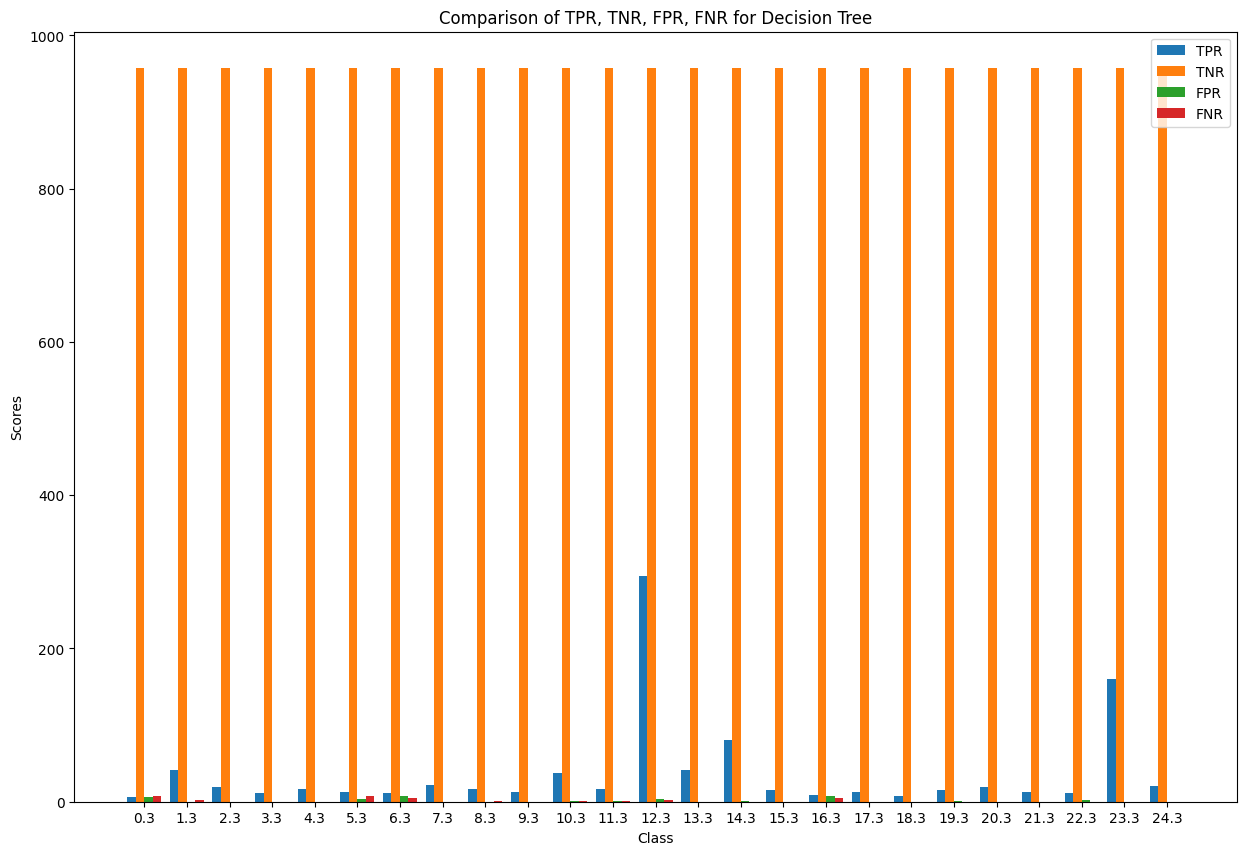

In [12]:
# Plot TPR, TNR, FPR, FNR for Decision Tree
fig, ax = plt.subplots(figsize=(15, 10))

bar_width = 0.2
index = np.arange(25)  # Assuming you have 25 classes, adjust this based on your data

bar1 = ax.bar(index, TP_dt, bar_width, label='TPR')
bar2 = ax.bar(index + bar_width, TN_dt, bar_width, label='TNR')
bar3 = ax.bar(index + 2 * bar_width, FP_dt, bar_width, label='FPR')
bar4 = ax.bar(index + 3 * bar_width, FN_dt, bar_width, label='FNR')

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Comparison of TPR, TNR, FPR, FNR for Decision Tree')
ax.set_xticks(index + 1.5 * bar_width)
ax.legend()

plt.show()

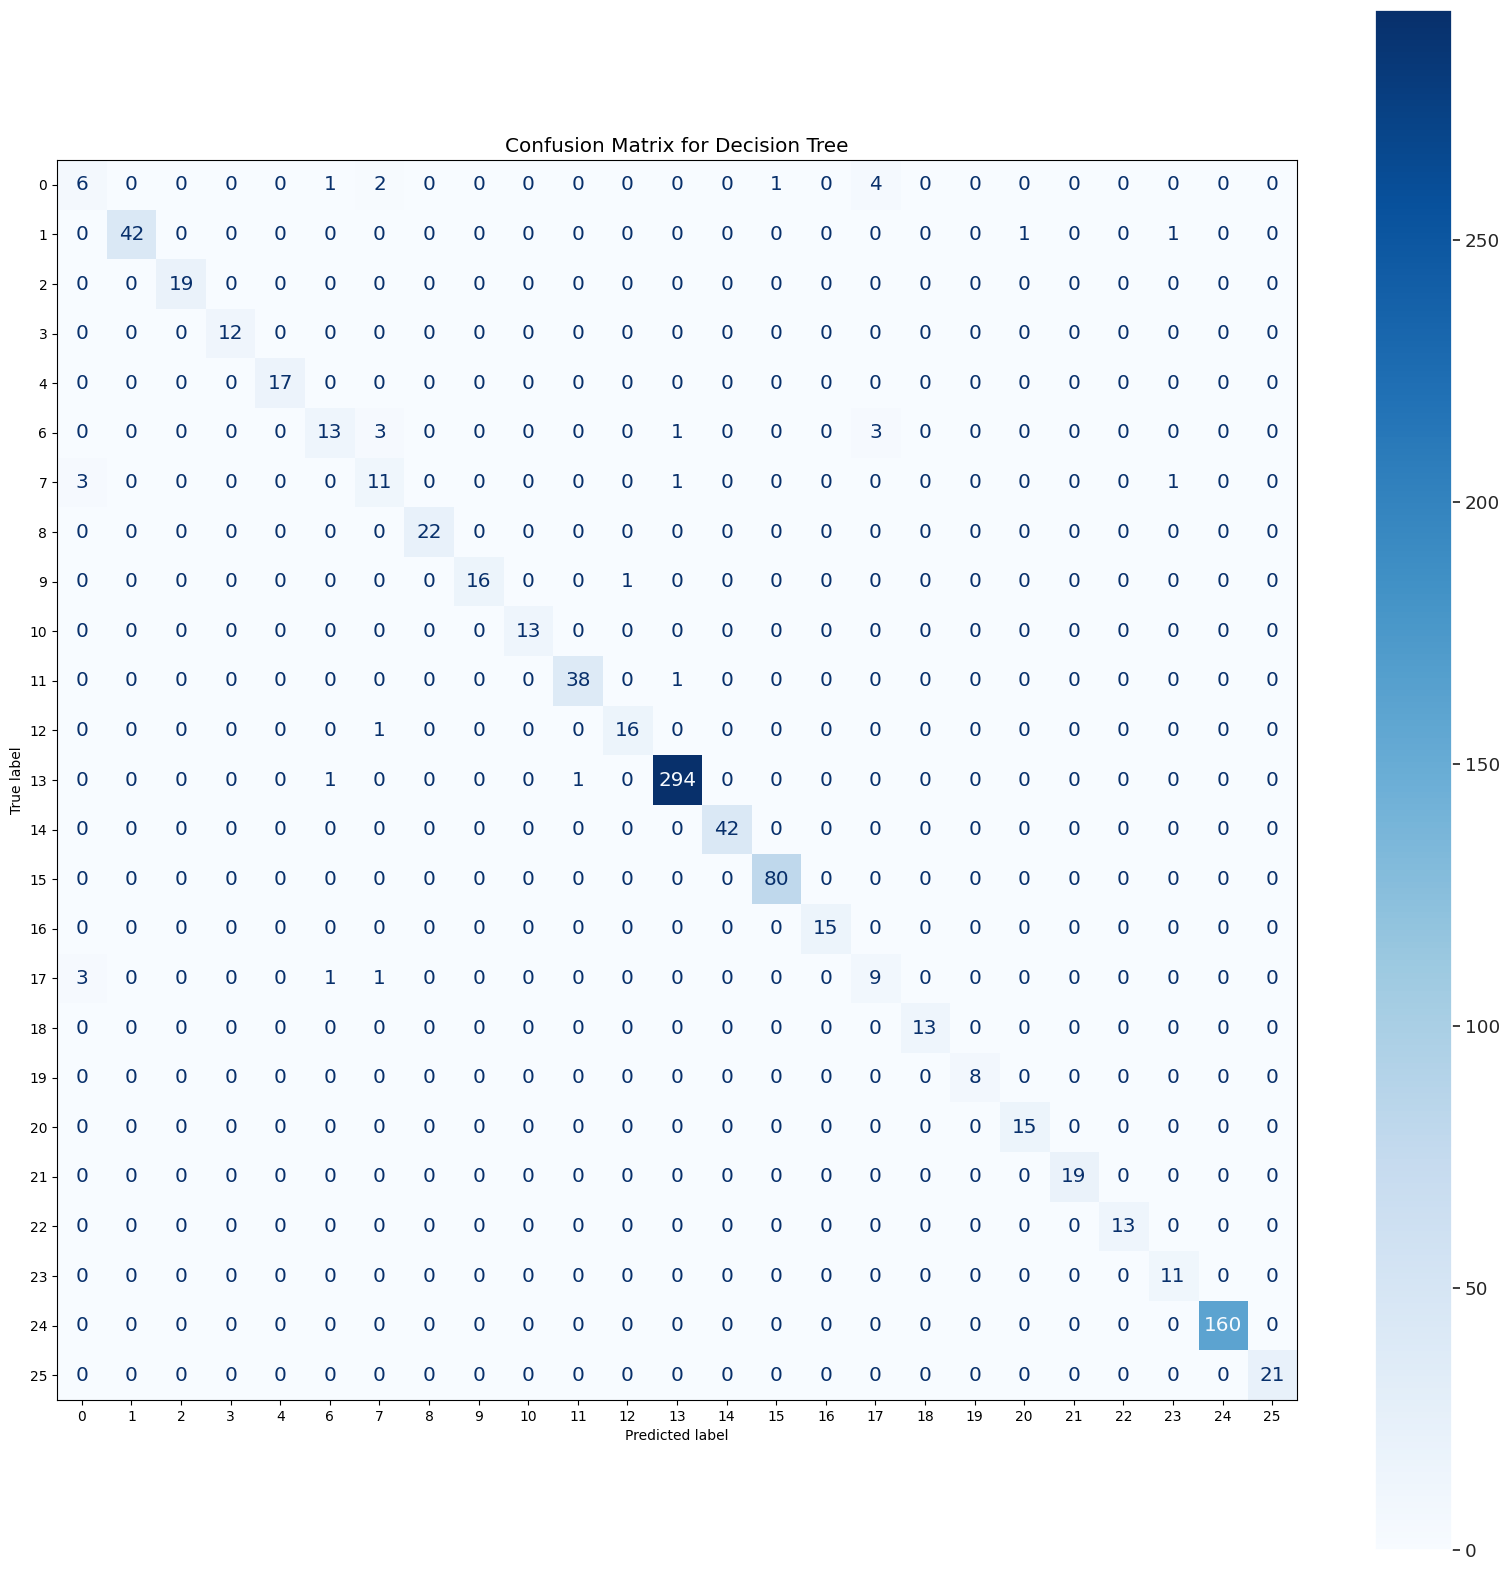

In [13]:
# Plot Confusion Matrix for Decision Tree
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.2)  # Adjust font size for better readability
disp = ConfusionMatrixDisplay(conf_matrix_dt, display_labels=np.unique(test_labels))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix for Decision Tree')
plt.show()